In [1]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Harmonizing the Datasets (CIC-IDS2017 & CIC-IDS2018)**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

class CICIDSHarmonizer:
    def __init__(self):
        # Feature mapping between CICIDS2017 and CICIDS2018
        self.feature_mapping = {
            'Destination Port': 'dst_port',
            # Basic flow features
            'Flow Duration': 'flow_duration',
            'Total Fwd Packets': 'tot_fwd_pkts',
            'Total Backward Packets': 'tot_bwd_pkts',
            'Total Length of Fwd Packets': 'totlen_fwd_pkts',
            'Total Length of Bwd Packets': 'totlen_bwd_pkts',

            # Packet length features
            'Fwd Packet Length Max': 'fwd_pkt_len_max',
            'Fwd Packet Length Min': 'fwd_pkt_len_min',
            'Fwd Packet Length Mean': 'fwd_pkt_len_mean',
            'Fwd Packet Length Std': 'fwd_pkt_len_std',
            'Bwd Packet Length Max': 'bwd_pkt_len_max',
            'Bwd Packet Length Min': 'bwd_pkt_len_min',
            'Bwd Packet Length Mean': 'bwd_pkt_len_mean',
            'Bwd Packet Length Std': 'bwd_pkt_len_std',

            # Flow timing features
            'Flow Bytes/s': 'flow_byts_s',
            'Flow Packets/s': 'flow_pkts_s',
            'Flow IAT Mean': 'flow_iat_mean',
            'Flow IAT Std': 'flow_iat_std',
            'Flow IAT Max': 'flow_iat_max',
            'Flow IAT Min': 'flow_iat_min',

            # Forward IAT features
            'Fwd IAT Total': 'fwd_iat_tot',
            'Fwd IAT Mean': 'fwd_iat_mean',
            'Fwd IAT Std': 'fwd_iat_std',
            'Fwd IAT Max': 'fwd_iat_max',
            'Fwd IAT Min': 'fwd_iat_min',

            # Backward IAT features
            'Bwd IAT Total': 'bwd_iat_tot',
            'Bwd IAT Mean': 'bwd_iat_mean',
            'Bwd IAT Std': 'bwd_iat_std',
            'Bwd IAT Max': 'bwd_iat_max',
            'Bwd IAT Min': 'bwd_iat_min',

            # Header and flag features
            'Fwd PSH Flags': 'fwd_psh_flags',
            'Fwd URG Flags': 'fwd_urg_flags',
            'Fwd Header Length': 'fwd_header_len',
            'Bwd Header Length': 'bwd_header_len',
            'Fwd Packets/s': 'fwd_pkts_s',
            'Bwd Packets/s': 'bwd_pkts_s',

            # Packet size features
            'Min Packet Length': 'pkt_len_min',
            'Max Packet Length': 'pkt_len_max',
            'Packet Length Mean': 'pkt_len_mean',
            'Packet Length Std': 'pkt_len_std',
            'Packet Length Variance': 'pkt_len_var',

            # TCP flag features
            'FIN Flag Count': 'fin_flag_cnt',
            'SYN Flag Count': 'syn_flag_cnt',
            'RST Flag Count': 'rst_flag_cnt',
            'PSH Flag Count': 'psh_flag_cnt',
            'ACK Flag Count': 'ack_flag_cnt',
            'URG Flag Count': 'urg_flag_cnt',
            'CWE Flag Count': 'cwe_flag_count',
            'ECE Flag Count': 'ece_flag_cnt',

            # Additional flow features
            'Down/Up Ratio': 'down_up_ratio',
            'Average Packet Size': 'pkt_size_avg',
            'Avg Fwd Segment Size': 'fwd_seg_size_avg',
            'Avg Bwd Segment Size': 'bwd_seg_size_avg',

            # Subflow features
            'Subflow Fwd Packets': 'subflow_fwd_pkts',
            'Subflow Fwd Bytes': 'subflow_fwd_byts',
            'Subflow Bwd Packets': 'subflow_bwd_pkts',
            'Subflow Bwd Bytes': 'subflow_bwd_byts',

            # Window and segment features
            'Init_Win_bytes_forward': 'init_fwd_win_byts',
            'Init_Win_bytes_backward': 'init_bwd_win_byts',
            'act_data_pkt_fwd': 'fwd_act_data_pkts',
            'min_seg_size_forward': 'fwd_seg_size_min',

            # Activity features
            'Active Mean': 'active_mean',
            'Active Std': 'active_std',
            'Active Max': 'active_max',
            'Active Min': 'active_min',
            'Idle Mean': 'idle_mean',
            'Idle Std': 'idle_std',
            'Idle Max': 'idle_max',
            'Idle Min': 'idle_min'
        }

        # Label mappings for both datasets to common categories
        self.label_mapping_2017 = {
            'Benign': 'Benign',
            'Bruteforce': 'Brute Force',
            'DDoS': 'DDoS',
            'DoS': 'DoS',
            'Web Attack': 'Web Attack',
            'Infiltration': 'Infiltration',
            'Bot': 'Bot',
            'Heartbleed': 'Other',
            'Port Scan': 'Port Scan'
        }

        self.label_mapping_2018 = {
            'Benign': 'Benign',
            'Bot': 'Bot',
            'Brute Force -Web': 'Web Attack',
            'Brute Force -XSS': 'Web Attack',
            'SQL Injection': 'Web Attack',
            'Infiltration': 'Infiltration',
            'FTP-BruteForce': 'Brute Force',
            'SSH-Bruteforce': 'Brute Force',
            'DoS attacks-GoldenEye': 'DoS',
            'DoS attacks-Hulk': 'DoS',
            'DoS attacks-Slowloris': 'DoS',
            'DoS attacks-SlowHTTPTest': 'DoS',
            'DDoS attacks-LOIC-HTTP': 'DDoS',
            'DDOS attack-LOIC-UDP': 'DDoS',
            'DDOS attack-HOIC': 'DDoS'
        }

        self.scaler = StandardScaler()
        self.original_2017_order = None

    def harmonize_datasets(self, df_2017, df_2018):
        """
        Harmonize datasets while strictly preserving the original 2017 column order
        """
        print("=== Starting Order-Preserving Harmonization ===")

        # Store theoriginal column order from 2017
        self.original_2017_order = df_2017.columns.tolist()
        print(f"Original 2017 columns: {len(self.original_2017_order)}")

        # Clean 2017 dataset while preserving order
        df_2017_clean = self._clean_2017(df_2017.copy())

        # Clean and map 2018 dataset to match 2017 structure
        df_2018_clean = self._clean_and_map_2018(df_2018.copy())

        # Find which columns from original 2017 that can be kept
        available_2018_cols = set(df_2018_clean.columns)
        available_2017_cols = set(df_2017_clean.columns)

        # Create the final column order based on original 2017 order
        final_columns = []
        excluded_columns = []

        for col in self.original_2017_order:
            if col in available_2017_cols and col in available_2018_cols:
                final_columns.append(col)
            else:
                excluded_columns.append(col)

        print(f"Keeping {len(final_columns)} columns in original order")
        print(f"Excluding {len(excluded_columns)} columns: {excluded_columns}")

        # elect columns in the exact original order
        df_2017_final = df_2017_clean[final_columns].copy()
        df_2018_final = df_2018_clean[final_columns].copy()

        print(f"Final shapes - 2017: {df_2017_final.shape}, 2018: {df_2018_final.shape}")
        print(" Original column order preserved!")

        return df_2017_final, df_2018_final

    def _clean_2017(self, df):
        """Clean 2017 dataset while preserving exact column order"""
        print("Cleaning CICIDS2017...")

        # Clean column names but preserve order
        col_names = {col: col.strip() for col in df.columns}
        df.rename(columns=col_names, inplace=True)

        # Handle infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Impute missing values
        if 'Flow Bytes/s' in df.columns:
            df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].median(), inplace=True)
        if 'Flow Packets/s' in df.columns:
            df['Flow Packets/s'].fillna(df['Flow Packets/s'].median(), inplace=True)

        # Remove duplicates
        df.drop_duplicates(inplace=True)

        # Map labels to common format
        if 'Label' in df.columns:
            df['Label'] = df['Label'].map(self.label_mapping_2017)

        # Create binary target
        if 'Target' not in df.columns:
            df['Target'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

        # Remove columns that are unique to 2017 and don't exist in 2018
        cols_to_remove = ['Fwd Header Length.1']
        for col in cols_to_remove:
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
                print(f"Removed 2017-specific column: {col}")

        return df

    def _clean_and_map_2018(self, df):
        """Clean 2018 dataset and map column names to match 2017"""
        print("Cleaning and mapping CICIDS2018...")

        # Handle infinite values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

        # Impute missing values with median
        for col in numeric_cols:
            if df[col].isna().sum() > 0:
                df[col].fillna(df[col].median(), inplace=True)

        # Remove duplicates
        df.drop_duplicates(inplace=True)

        # Remove 2018-specific columns that don't exist in 2017
        cols_to_remove = ['protocol', 'timestamp']
        for col in cols_to_remove:
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
                print(f"Removed 2018-specific column: {col}")

        # Map 2018 column names to 2017 format
        reverse_mapping = {v: k for k, v in self.feature_mapping.items()}
        rename_dict = {}

        for col in df.columns:
            if col in reverse_mapping:
                rename_dict[col] = reverse_mapping[col]

        df.rename(columns=rename_dict, inplace=True)
        print(f"Mapped {len(rename_dict)} column names to 2017 format")

        # Handle labels
        if 'label' in df.columns:
            df['Label'] = df['label'].map(self.label_mapping_2018)
            df['Label'].fillna('Other', inplace=True)
            df.drop('label', axis=1, inplace=True)

        if 'label_code' in df.columns:
            df.drop('label_code', axis=1, inplace=True)

        # Create binary target
        if 'Label' in df.columns and 'Target' not in df.columns:
            df['Target'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

        return df


In [3]:
# Load the datasets
df_2017 = pd.read_csv('/content/drive/MyDrive/preprocessed_cicids2017.csv')
df_2018 = pd.read_csv('/content/drive/MyDrive/balanced_data.csv')

# Initialize harmonizer
harmonizer = CICIDSHarmonizer()

# Harmonize datasets while preserving original 2017 order
df_2017_final, df_2018_final = harmonizer.harmonize_datasets(df_2017, df_2018)

print(f"CICIDS2017 saved: {df_2017_final.shape}")
print(f"CICIDS2018 saved: {df_2018_final.shape}")

=== Starting Order-Preserving Harmonization ===
Original 2017 columns: 72
Cleaning CICIDS2017...


/tmp/ipython-input-2456971172.py:192: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].median(), inplace=True)
/tmp/ipython-input-2456971172.py:194: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

Removed 2017-specific column: Fwd Header Length.1
Cleaning and mapping CICIDS2018...
Removed 2018-specific column: protocol
Removed 2018-specific column: timestamp
Mapped 69 column names to 2017 format


/tmp/ipython-input-2456971172.py:253: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Label'].fillna('Other', inplace=True)


Keeping 71 columns in original order
Excluding 1 columns: ['Fwd Header Length.1']
Final shapes - 2017: (2522362, 71), 2018: (4708496, 71)
 Original column order preserved!
CICIDS2017 saved: (2522362, 71)
CICIDS2018 saved: (4708496, 71)


In [4]:
df_2018_final.to_csv('harmonized_2018_dataset.csv', index=False)

## **Benchmark Comparison and Cross Dataset Generalization**

In [5]:
!pip install stable_baselines3
!pip install gym
!pip install shimmy
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# For PPO
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.env_util import make_vec_env
    from stable_baselines3.common.vec_env import DummyVecEnv
    import gym
    from gym import spaces
    PPO_AVAILABLE = True
except ImportError:
    print("Warning: stable-baselines3 not available. PPO model will be skipped.")
    PPO_AVAILABLE = False

class CICIDSComparisonFramework:
    def __init__(self):
        self.models = {}
        self.results_2017 = {}
        self.results_2018 = {}
        self.training_times = {}
        self.prediction_times_2017 = {}
        self.prediction_times_2018 = {}

    def prepare_data(self, df_2017, df_2018):
        """Prepare data for training and testing"""
        print("=== Data Preparation ===")

        # Separate features and labels
        feature_cols = [col for col in df_2017.columns if col not in ['Label', 'Target']]

        # Training data (2017)
        X_train_full = df_2017[feature_cols]
        y_train_full = df_2017['Target']

        # Test data (2018)
        X_test_2018 = df_2018[feature_cols]
        y_test_2018 = df_2018['Target']

        # Split 2018 for testing
        X_test_2018_sample, _, y_test_2018_sample, _ = train_test_split(
            X_test_2018, y_test_2018,
            train_size=100000,
            random_state=42,
            stratify=y_test_2018
        )

        # Split 2017 for training/validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
        )

        # Create test set from 2017 validation set for evaluation
        X_test_2017_sample, _, y_test_2017_sample, _ = train_test_split(
            X_val, y_val,
            train_size=50000,
            random_state=42,
            stratify=y_val
        )

        print(f"Training set (2017): {X_train.shape}")
        print(f"2017 Test set: {X_test_2017_sample.shape}")
        print(f"2018 Test set: {X_test_2018_sample.shape}")
        print(f"Number of features: {len(feature_cols)}")

        # Scale features for neural networks and logistic regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_2017_scaled = scaler.transform(X_test_2017_sample)
        X_test_2018_scaled = scaler.transform(X_test_2018_sample)

        return {
            'X_train': X_train, 'y_train': y_train,
            'X_test_2017': X_test_2017_sample, 'y_test_2017': y_test_2017_sample,
            'X_test_2018': X_test_2018_sample, 'y_test_2018': y_test_2018_sample,
            'X_train_scaled': X_train_scaled,
            'X_test_2017_scaled': X_test_2017_scaled,
            'X_test_2018_scaled': X_test_2018_scaled,
            'feature_names': feature_cols,
            'scaler': scaler
        }

    def train_random_forest(self, data):
        """Train Random Forest model"""
        print("\n=== Training Random Forest ===")

        start_time = time.time()

        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )

        rf.fit(data['X_train'], data['y_train'])

        training_time = time.time() - start_time

        self.models['Random Forest'] = rf
        self.training_times['Random Forest'] = training_time

        print(f"Training completed in {training_time:.2f} seconds")
        return rf

    def train_logistic_regression(self, data):
        """Train Logistic Regression model"""
        print("\n=== Training Logistic Regression ===")

        start_time = time.time()

        lr = LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        )

        lr.fit(data['X_train_scaled'], data['y_train'])

        training_time = time.time() - start_time

        self.models['Logistic Regression'] = lr
        self.training_times['Logistic Regression'] = training_time

        print(f"Training completed in {training_time:.2f} seconds")
        return lr

    def train_neural_network(self, data):
        """Train Neural Network model"""
        print("\n=== Training Neural Network ===")

        start_time = time.time()

        nn = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size='auto',
            learning_rate='adaptive',
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )

        nn.fit(data['X_train_scaled'], data['y_train'])

        training_time = time.time() - start_time

        self.models['Neural Network'] = nn
        self.training_times['Neural Network'] = training_time

        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Final training loss: {nn.loss_:.4f}")
        return nn

    def create_rl_environment(self, X, y):
        """Create custom environment for PPO"""
        class CICIDSEnv(gym.Env):
            def __init__(self, X, y):
                super(CICIDSEnv, self).__init__()
                self.X = X
                self.y = y
                self.current_idx = 0
                self.max_steps = len(X)

                # Action space: 0 = Benign, 1 = Attack
                self.action_space = spaces.Discrete(2)

                # Observation space: feature vector
                self.observation_space = spaces.Box(
                    low=-np.inf, high=np.inf,
                    shape=(X.shape[1],), dtype=np.float32
                )

            def step(self, action):
                if self.current_idx >= self.max_steps:
                    self.current_idx = 0

                # Get current observation and true label
                obs = self.X[self.current_idx].astype(np.float32)
                true_label = self.y.iloc[self.current_idx]

                # Calculate reward (1 for correct, -1 for incorrect)
                reward = 1.0 if action == true_label else -1.0

                self.current_idx += 1
                done = self.current_idx >= self.max_steps

                return obs, reward, done, {}

            def reset(self):
                self.current_idx = 0
                return self.X[0].astype(np.float32)

        return CICIDSEnv(X, y)

    def train_ppo(self, data):
        """Train PPO model"""
        if not PPO_AVAILABLE:
            print("\n=== PPO Training Skipped (stable-baselines3 not available) ===")
            return None

        print("\n=== Training PPO ===")

        start_time = time.time()

        # Create environment
        env = self.create_rl_environment(data['X_train_scaled'], data['y_train'])
        env = DummyVecEnv([lambda: env])

        # Create PPO model
        ppo = PPO(
            "MlpPolicy",
            env,
            verbose=0,
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
        )

        # Train the model
        ppo.learn(total_timesteps=50000)

        training_time = time.time() - start_time

        self.models['PPO'] = ppo
        self.training_times['PPO'] = training_time

        print(f"Training completed in {training_time:.2f} seconds")
        return ppo

    def evaluate_model(self, model_name, model, data, dataset='2018', use_scaled=False):
        """Evaluate a single model on specified dataset"""
        print(f"\n=== Evaluating {model_name} on CICIDS{dataset} ===")

        if dataset == '2017':
            X_test = data['X_test_2017_scaled'] if use_scaled else data['X_test_2017']
            y_test = data['y_test_2017']
            results_dict = self.results_2017
            times_dict = self.prediction_times_2017
        else:
            X_test = data['X_test_2018_scaled'] if use_scaled else data['X_test_2018']
            y_test = data['y_test_2018']
            results_dict = self.results_2018
            times_dict = self.prediction_times_2018

        start_time = time.time()

        if model_name == 'PPO' and PPO_AVAILABLE:
            predictions = []
            env = self.create_rl_environment(X_test, y_test)
            obs = env.reset()

            for _ in range(len(y_test)):
                action, _ = model.predict(obs, deterministic=True)
                predictions.append(action)
                obs, _, done, _ = env.step(action)
                if done:
                    obs = env.reset()

            y_pred = np.array(predictions)
        else:
            y_pred = model.predict(X_test)

        prediction_time = time.time() - start_time
        times_dict[model_name] = prediction_time

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        # Store results
        results_dict[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Prediction time: {prediction_time:.2f} seconds")

        return y_pred

    def train_all_models(self, data):
        """Train all models"""
        print("=== Training All Models ===")

        # Train each model
        self.train_random_forest(data)
        self.train_logistic_regression(data)
        self.train_neural_network(data)
        if PPO_AVAILABLE:
            self.train_ppo(data)

        print("\n=== All Models Trained Successfully ===")

    def evaluate_all_models(self, data):
        """Evaluate all trained models on both datasets"""
        print("\n=== Evaluating All Models on Both Datasets ===")

        # Evaluate on CICIDS2017
        print("\n" + "="*60)
        print("EVALUATING ON CICIDS2017 (Training Dataset)")
        print("="*60)

        for model_name in self.models:
            if model_name == 'Random Forest':
                self.evaluate_model(model_name, self.models[model_name], data, dataset='2017', use_scaled=False)
            elif model_name in ['Logistic Regression', 'Neural Network', 'PPO']:
                self.evaluate_model(model_name, self.models[model_name], data, dataset='2017', use_scaled=True)

        # Evaluate on CICIDS2018
        print("\n" + "="*60)
        print("EVALUATING ON CICIDS2018 (Generalization Dataset)")
        print("="*60)

        for model_name in self.models:
            if model_name == 'Random Forest':
                self.evaluate_model(model_name, self.models[model_name], data, dataset='2018', use_scaled=False)
            elif model_name in ['Logistic Regression', 'Neural Network', 'PPO']:
                self.evaluate_model(model_name, self.models[model_name], data, dataset='2018', use_scaled=True)

    def create_comparison_report(self):
        """Create comprehensive comparison report for both datasets"""
        print("\n" + "="*100)
        print("COMPREHENSIVE MODEL COMPARISON REPORT - DUAL DATASET EVALUATION")
        print("="*100)

        # Performance comparison table for both datasets
        print("\n PERFORMANCE METRICS COMPARISON:")
        print("-" * 100)
        print(f"{'Model':<18} {'2017 Acc':<10} {'2017 F1':<10} {'2018 Acc':<10} {'2018 F1':<10} {'Generalization Gap':<18}")
        print("-" * 100)

        for model_name in self.models:
            results_2017 = self.results_2017.get(model_name, {})
            results_2018 = self.results_2018.get(model_name, {})

            acc_2017 = results_2017.get('accuracy', 0)
            f1_2017 = results_2017.get('f1_score', 0)
            acc_2018 = results_2018.get('accuracy', 0)
            f1_2018 = results_2018.get('f1_score', 0)

            # Calculate generalization gap (difference in accuracy)
            gen_gap = acc_2017 - acc_2018

            print(f"{model_name:<18} {acc_2017:<10.4f} {f1_2017:<10.4f} {acc_2018:<10.4f} "
                  f"{f1_2018:<10.4f} {gen_gap:<18.4f}")

        # Detailed metrics table
        print(f"\n DETAILED METRICS:")
        print("-" * 100)
        print(f"{'Dataset':<10} {'Model':<18} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
        print("-" * 100)

        for dataset, results_dict in [('2017', self.results_2017), ('2018', self.results_2018)]:
            for model_name, results in results_dict.items():
                print(f"{dataset:<10} {model_name:<18} {results['accuracy']:<10.4f} "
                      f"{results['precision']:<10.4f} {results['recall']:<10.4f} {results['f1_score']:<10.4f}")

        # Training time comparison
        print(f"\n  TRAINING TIMES:")
        print("-" * 40)
        for model_name, time_val in self.training_times.items():
            print(f"{model_name:<18}: {time_val:.2f} seconds")

        # Prediction time comparison
        print(f"\n PREDICTION TIMES:")
        print("-" * 60)
        print(f"{'Model':<18} {'2017 Dataset':<15} {'2018 Dataset':<15}")
        print("-" * 60)
        for model_name in self.models:
            time_2017 = self.prediction_times_2017.get(model_name, 0)
            time_2018 = self.prediction_times_2018.get(model_name, 0)
            print(f"{model_name:<18} {time_2017:<15.2f} {time_2018:<15.2f}")

        # Best model identification
        if self.results_2017 and self.results_2018:
            best_2017_acc = max(self.results_2017.items(), key=lambda x: x[1]['accuracy'])
            best_2018_acc = max(self.results_2018.items(), key=lambda x: x[1]['accuracy'])
            best_2017_f1 = max(self.results_2017.items(), key=lambda x: x[1]['f1_score'])
            best_2018_f1 = max(self.results_2018.items(), key=lambda x: x[1]['f1_score'])

            # Find best generalization (smallest gap)
            gen_gaps = {}
            for model_name in self.models:
                if model_name in self.results_2017 and model_name in self.results_2018:
                    gap = self.results_2017[model_name]['accuracy'] - self.results_2018[model_name]['accuracy']
                    gen_gaps[model_name] = gap

            best_generalization = min(gen_gaps.items(), key=lambda x: x[1]) if gen_gaps else None

            print(f"\n BEST PERFORMERS:")
            print("-" * 50)
            print(f"Best 2017 Accuracy    : {best_2017_acc[0]} ({best_2017_acc[1]['accuracy']:.4f})")
            print(f"Best 2018 Accuracy    : {best_2018_acc[0]} ({best_2018_acc[1]['accuracy']:.4f})")
            print(f"Best 2017 F1-Score    : {best_2017_f1[0]} ({best_2017_f1[1]['f1_score']:.4f})")
            print(f"Best 2018 F1-Score    : {best_2018_f1[0]} ({best_2018_f1[1]['f1_score']:.4f})")
            if best_generalization:
                print(f"Best Generalization   : {best_generalization[0]} (gap: {best_generalization[1]:.4f})")

        print("="*100)

    def plot_comparison_charts(self):
        """Create enhanced visualization plots for dual dataset comparison"""
        if not self.results_2017 or not self.results_2018:
            return

        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))
        fig.suptitle('Enhanced Model Comparison: CICIDS2017 vs CICIDS2018', fontsize=16)

        models = list(self.models.keys())

        # Accuracy comparison between datasets
        acc_2017 = [self.results_2017[m]['accuracy'] for m in models]
        acc_2018 = [self.results_2018[m]['accuracy'] for m in models]

        x = np.arange(len(models))
        width = 0.35

        axes[0,0].bar(x - width/2, acc_2017, width, label='CICIDS2017', alpha=0.8, color='skyblue')
        axes[0,0].bar(x + width/2, acc_2018, width, label='CICIDS2018', alpha=0.8, color='lightcoral')
        axes[0,0].set_xlabel('Models')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].set_title('Accuracy Comparison: 2017 vs 2018')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(models, rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # F1-Score comparison between datasets
        f1_2017 = [self.results_2017[m]['f1_score'] for m in models]
        f1_2018 = [self.results_2018[m]['f1_score'] for m in models]

        axes[0,1].bar(x - width/2, f1_2017, width, label='CICIDS2017', alpha=0.8, color='lightgreen')
        axes[0,1].bar(x + width/2, f1_2018, width, label='CICIDS2018', alpha=0.8, color='orange')
        axes[0,1].set_xlabel('Models')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].set_title('F1-Score Comparison: 2017 vs 2018')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(models, rotation=45)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Generalization Gap (difference in accuracy)
        gen_gaps = [acc_2017[i] - acc_2018[i] for i in range(len(models))]
        colors = ['red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green' for gap in gen_gaps]

        axes[1,0].bar(models, gen_gaps, color=colors, alpha=0.7)
        axes[1,0].set_xlabel('Models')
        axes[1,0].set_ylabel('Accuracy Gap (2017 - 2018)')
        axes[1,0].set_title('Generalization Gap Analysis')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Training vs Prediction Time
        training_times = [self.training_times.get(model, 0) for model in models]
        pred_times_avg = [(self.prediction_times_2017.get(model, 0) +
                          self.prediction_times_2018.get(model, 0)) / 2 for model in models]

        axes[1,1].scatter(training_times, pred_times_avg, s=100, alpha=0.7, c=range(len(models)), cmap='viridis')
        for i, model in enumerate(models):
            axes[1,1].annotate(model, (training_times[i], pred_times_avg[i]),
                             xytext=(5, 5), textcoords='offset points')
        axes[1,1].set_xlabel('Training Time (seconds)')
        axes[1,1].set_ylabel('Average Prediction Time (seconds)')
        axes[1,1].set_title('Training vs Prediction Time')
        axes[1,1].grid(True, alpha=0.3)

        # Performance Heatmap
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        data_2017 = np.array([[self.results_2017[m][metric] for metric in metrics] for m in models])
        data_2018 = np.array([[self.results_2018[m][metric] for metric in metrics] for m in models])

        # Combined heatmap
        combined_data = np.hstack([data_2017, data_2018])
        combined_labels = [f'2017_{m}' for m in metrics] + [f'2018_{m}' for m in metrics]

        im = axes[2,0].imshow(combined_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        axes[2,0].set_xticks(range(len(combined_labels)))
        axes[2,0].set_xticklabels(combined_labels, rotation=45, ha='right')
        axes[2,0].set_yticks(range(len(models)))
        axes[2,0].set_yticklabels(models)
        axes[2,0].set_title('Performance Metrics Heatmap')

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[2,0])
        cbar.set_label('Performance Score')

        # Generalization Performance Scatter
        axes[2,1].scatter(acc_2017, acc_2018, s=100, alpha=0.7)
        for i, model in enumerate(models):
            axes[2,1].annotate(model, (acc_2017[i], acc_2018[i]),
                             xytext=(5, 5), textcoords='offset points')

        # Add diagonal line for perfect generalization
        min_acc = min(min(acc_2017), min(acc_2018))
        max_acc = max(max(acc_2017), max(acc_2018))
        axes[2,1].plot([min_acc, max_acc], [min_acc, max_acc], 'r--', alpha=0.5, label='Perfect Generalization')

        axes[2,1].set_xlabel('CICIDS2017 Accuracy')
        axes[2,1].set_ylabel('CICIDS2018 Accuracy')
        axes[2,1].set_title('Generalization Performance')
        axes[2,1].legend()
        axes[2,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 14.7 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


=== Data Preparation ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training set (2017): (2017889, 69)
2017 Test set: (50000, 69)
2018 Test set: (100000, 69)
Number of features: 69


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


=== Training All Models ===

=== Training Random Forest ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training completed in 142.49 seconds

=== Training Logistic Regression ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training completed in 74.17 seconds

=== Training Neural Network ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training completed in 2078.47 seconds
Final training loss: 0.0144

=== Training PPO ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training completed in 108.42 seconds

=== All Models Trained Successfully ===

=== Evaluating All Models on Both Datasets ===

EVALUATING ON CICIDS2017 (Training Dataset)

=== Evaluating Random Forest on CICIDS2017 ===
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F1-Score: 0.9988
Prediction time: 0.08 seconds

=== Evaluating Logistic Regression on CICIDS2017 ===
Accuracy: 0.9568
Precision: 0.9565
Recall: 0.9568
F1-Score: 0.9567
Prediction time: 0.00 seconds

=== Evaluating Neural Network on CICIDS2017 ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Accuracy: 0.9970
Precision: 0.9970
Recall: 0.9970
F1-Score: 0.9970
Prediction time: 0.48 seconds

=== Evaluating PPO on CICIDS2017 ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Accuracy: 0.8298
Precision: 0.7161
Recall: 0.8298
F1-Score: 0.7544
Prediction time: 34.43 seconds

EVALUATING ON CICIDS2018 (Generalization Dataset)

=== Evaluating Random Forest on CICIDS2018 ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Accuracy: 0.5050
Precision: 0.7354
Recall: 0.5050
F1-Score: 0.3447
Prediction time: 0.15 seconds

=== Evaluating Logistic Regression on CICIDS2018 ===
Accuracy: 0.5269
Precision: 0.5789
Recall: 0.5269
F1-Score: 0.4335
Prediction time: 0.02 seconds

=== Evaluating Neural Network on CICIDS2018 ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Accuracy: 0.5694
Precision: 0.7303
Recall: 0.5694
F1-Score: 0.4783
Prediction time: 0.93 seconds

=== Evaluating PPO on CICIDS2018 ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Accuracy: 0.4990
Precision: 0.4985
Recall: 0.4990
F1-Score: 0.4566
Prediction time: 69.25 seconds

COMPREHENSIVE MODEL COMPARISON REPORT - DUAL DATASET EVALUATION

 PERFORMANCE METRICS COMPARISON:
----------------------------------------------------------------------------------------------------
Model              2017 Acc   2017 F1    2018 Acc   2018 F1    Generalization Gap
----------------------------------------------------------------------------------------------------
Random Forest      0.9988     0.9988     0.5050     0.3447     0.4938            
Logistic Regression 0.9568     0.9567     0.5269     0.4335     0.4299            
Neural Network     0.9970     0.9970     0.5694     0.4783     0.4276            
PPO                0.8298     0.7544     0.4990     0.4566     0.3308            

 DETAILED METRICS:
----------------------------------------------------------------------------------------------------
Dataset    Model              Accuracy   Precision  Recall     F1-Sco

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


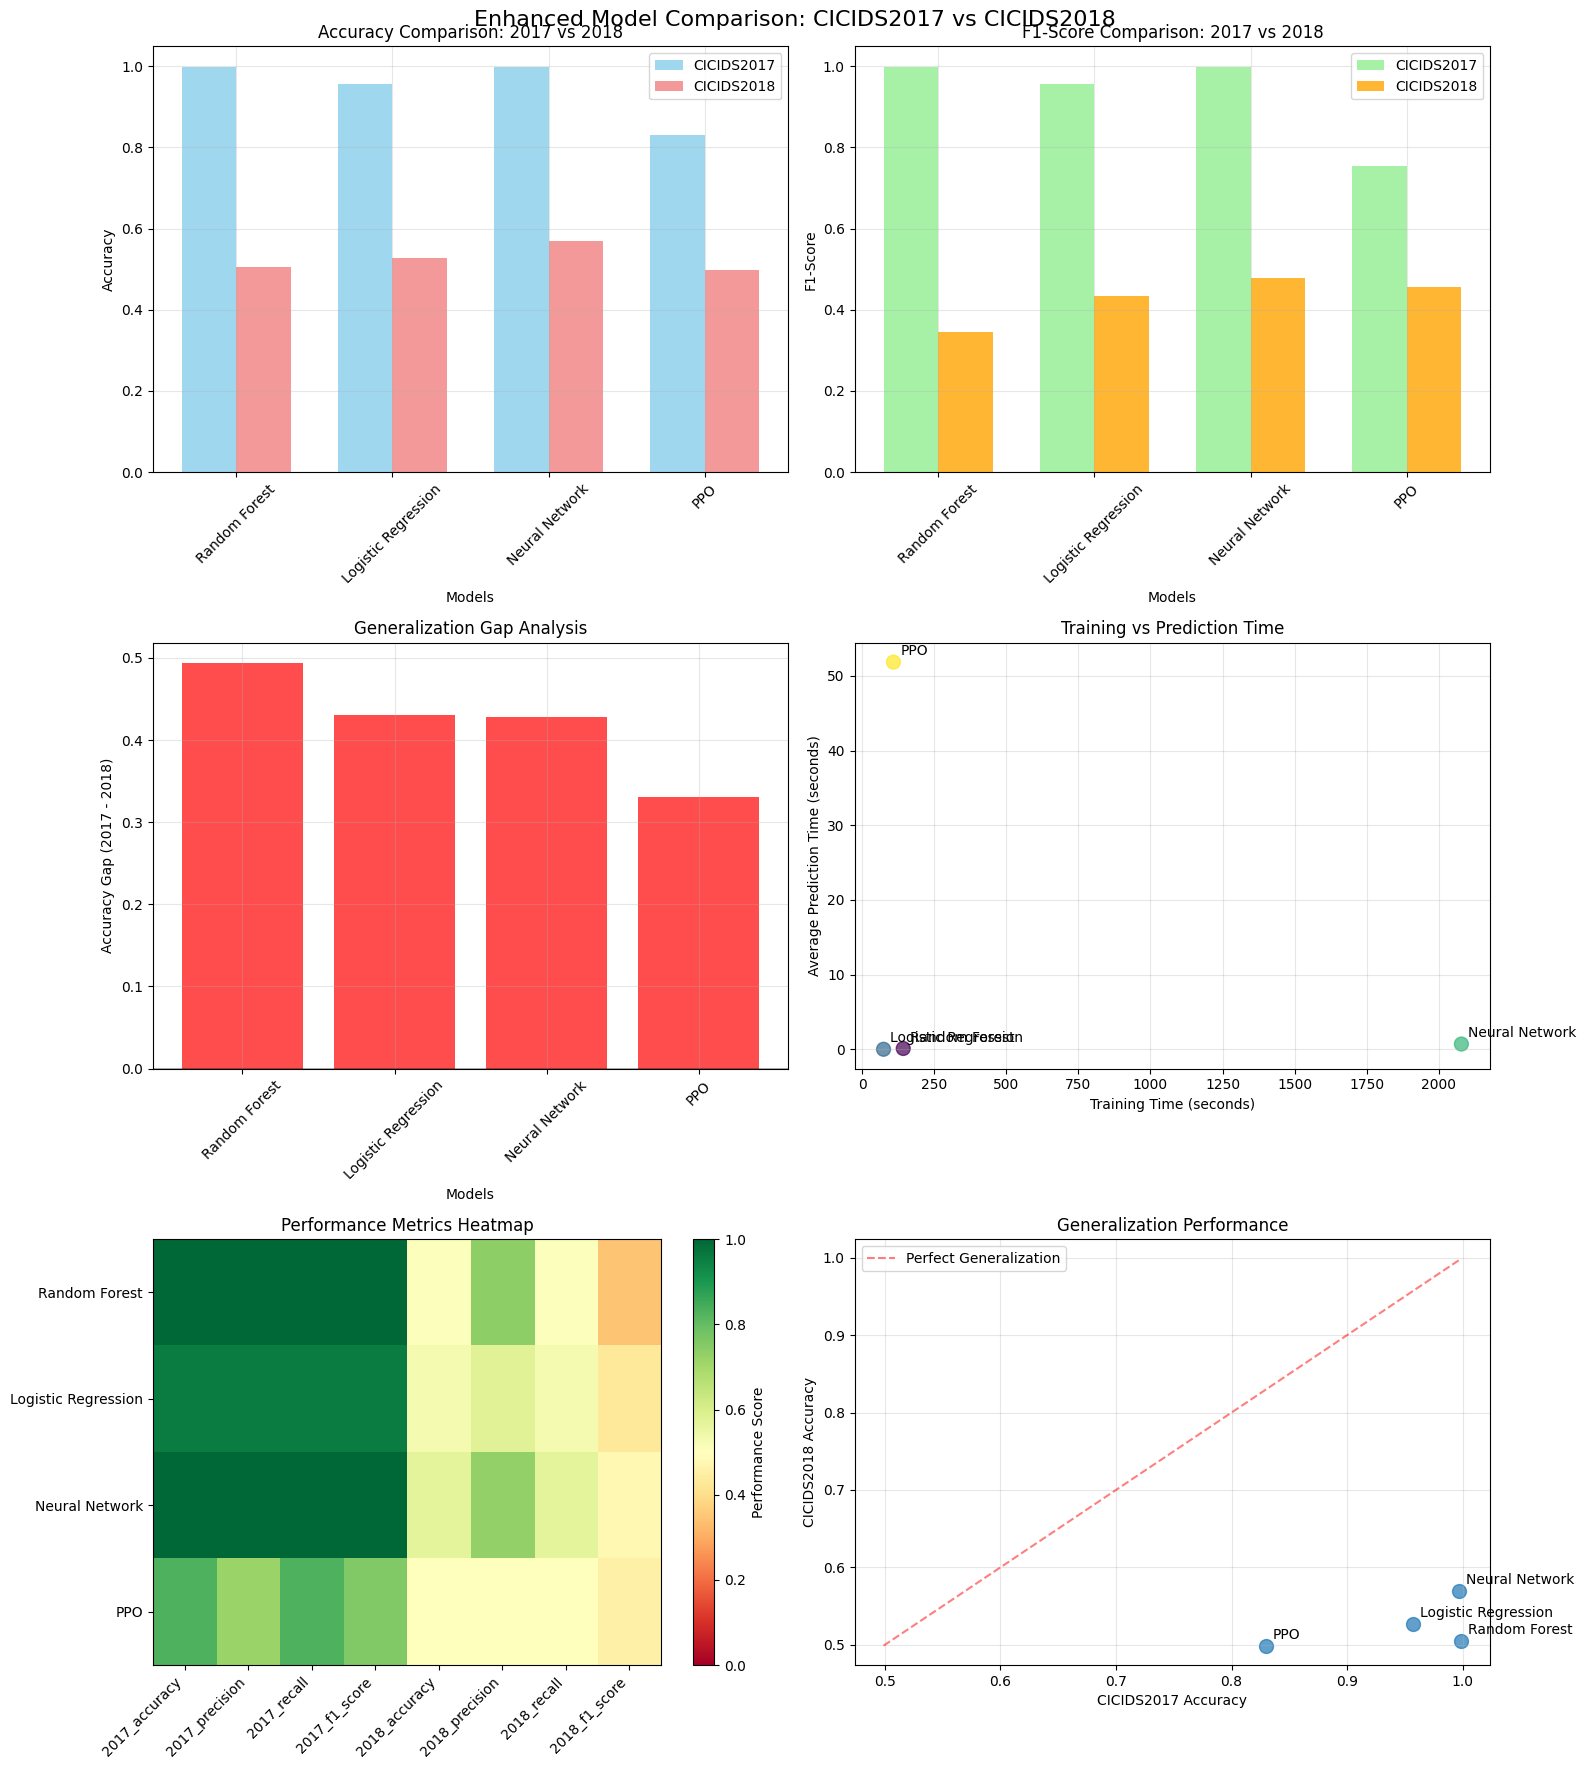


DETAILED CLASSIFICATION REPORTS

Random Forest - CICIDS2017 Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41558
           1       1.00      1.00      1.00      8442

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000


Random Forest - CICIDS2018 Results:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     50000
           1       0.97      0.01      0.02     50000

    accuracy                           0.51    100000
   macro avg       0.74      0.51      0.34    100000
weighted avg       0.74      0.51      0.34    100000


Logistic Regression - CICIDS2017 Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     41558
           1       0.88      0.86      0.87      8442

    accuracy                    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# Initialize enhanced comparison framework
comparison = CICIDSComparisonFramework()

# Prepare data
data = comparison.prepare_data(df_2017_final, df_2018_final)

# Train all models
comparison.train_all_models(data)

# Evaluate all models on both datasets
comparison.evaluate_all_models(data)

# Generate comprehensive report
comparison.create_comparison_report()

# Create enhanced visualization plots
comparison.plot_comparison_charts()

# Individual results for detailed analysis
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name in comparison.models:
    print(f"\n{model_name} - CICIDS2017 Results:")
    if model_name in comparison.results_2017:
        print(classification_report(data['y_test_2017'], comparison.results_2017[model_name]['predictions']))

    print(f"\n{model_name} - CICIDS2018 Results:")
    if model_name in comparison.results_2018:
        print(classification_report(data['y_test_2018'], comparison.results_2018[model_name]['predictions']))

